In [19]:
import numpy as np
import xarray as xr
from sklearn.cluster import KMeans
from cartopy.feature import NaturalEarthFeature
from cartopy.crs import PlateCarree
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize

from basic_functions import *
import datetime

import warnings
warnings.filterwarnings("ignore")

states, cart_proj = call_projection()

In [20]:
def call_projection():
    """Calls the PlateCarree projection for plots"""

    states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_0_boundary_lines_land")
    cart_proj = PlateCarree()
    return states, cart_proj

def time_preprocess(data):
    data["time"] = data["time"].dt.strftime("%Y-%m-%d").astype(np.datetime64)
    return data

def import_data(fname):
    """.nc file importation as a XArray
    ...
    Args:
    - fname = (str) path of the .nc file
    ...
    Returns:
    - data = imported data
    """
    data = xr.open_dataset(fname)
    return data

def extract_lonlats(data):
    """Grid extraction
    ...
    Args:
    - data = XArray file
    ...
    Returns:
    - lons, lats: longitude and latitude XArrays"""

    lons = data.lon
    lats = data.lat
    return lons, lats

def interpolate_data(data, lons, lats, method = "nearest"):
    """Data interpolation on the chosen grid
    ...
    Args:
    - data = Xarray file to interpolate
    - lons = Xarray file with longitudes
    - lats = Xarray file with latitudes
    - method = (str) nearest by default
    ...
    Returns:
    - data_interp = interpolated data"""

    data_interp = data.interp(lon = lons, lat = lats, method = method)
    return data_interp

def bathymetry_filter(data, bath, h = -1000):
    """ Removes coastal data (depth > h)
    ...
    Args:
    - a = NumPy array with the same grid of bathymetry
    - bath = NumPy array of bathymetry
    - h = reference depth (must be < 0) 
    ...
    Returns:
    - a_filt = NumPy array with coastal data removed"""

    data_filt = xr.where(bath.elevation < h, data, np.nan)
    return data_filt

def plot_data(lons, lats, data, cmap, fig = None, ax = None, cart_proj = PlateCarree(), cbar = True):

    if ax == None:
        fig = plt.figure()
        ax = plt.axes(projection = cart_proj)

    ax.add_feature(states, linewidth=.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)
    
    ax.set_xticks(np.arange(108,115,2), crs=cart_proj)
    ax.set_yticks(np.arange(10,20,2), crs=cart_proj)
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

    cmap = get_cmap(cmap, 10)
    c = ax.contourf(lons, lats, data, cmap = cmap)
    if cbar:
        plt.colorbar(c, ax = ax, orientation = "horizontal", shrink = 1)

    return ax

def climatology(data):
    data_clima = data.groupby("time.dayofyear").mean("time").rename({"dayofyear" : "time"})
    return data_clima

def anomalies(data, clima, date):
    day = datetime.datetime.strptime("2016-" + date[5:], "%Y-%m-%d").strftime("%j") 
    data_day = data.sel(time = date)
    data_clim = clima.sel(time = int(day))
    #space_std = data_day.std(["lon", "lat"])
    time_std = data.groupby("time.dayofyear").std("time", skipna = True).sel(dayofyear = int(day))

    data_diff = (data.sel(time = date) - clima.sel(time = int(day)))/(time_std)# + space_std)
    return data_diff

def cluster_data(chl, temp, date):

    chl_clima = climatology(chl)
    temp_clima = climatology(temp)

    chl_diff = anomalies(chl, chl_clima, date).CHL.to_numpy()
    temp_diff = anomalies(temp, temp_clima, date).analysed_sst.to_numpy()

    # chl_diff[np.isinf(chl_diff)] = np.nan
    # temp_diff[np.isinf(temp_diff)] = np.nan

    data = np.array(list(zip(chl_diff[~np.isnan(chl_diff)], temp_diff[~np.isnan(chl_diff)])))
    kmeans = KMeans(n_clusters = 2, init = "random")
    labels = kmeans.fit_predict(data)
    labels_matrix = np.empty(np.shape(chl_diff))
    labels_matrix[:,:] = np.nan
    mask = ~np.isnan(chl_diff)
    labels_matrix[mask] = labels.astype(int)
    return labels_matrix

def select_date(data, date):
    return data.sel(time = date)

In [8]:
chl = import_data("../data/SCS/CMEMS_chl_extended.nc")
temp = import_data("../data/SCS/CMEMS_temp_extended.nc")
chl, temp = time_preprocess(chl), time_preprocess(temp)
bath = import_data("../data/SCS/bathymetry.nc")

In [9]:
chl.groupby("time.dayofyear").std("time", skipna = True).sel(dayofyear = int(142))

<xarray.Dataset>
Dimensions:    (lat: 241, lon: 145)
Coordinates:
  * lon        (lon) float32 108.0 108.0 108.1 108.1 ... 113.9 113.9 113.9 114.0
  * lat        (lat) float32 19.02 18.98 18.94 18.9 ... 9.146 9.104 9.062 9.021
    dayofyear  int64 142
Data variables:
    CHL        (lat, lon) float32 0.09801 0.09608 0.1012 ... 0.01437 0.01671

In [11]:
lons, lats = extract_lonlats(temp)
chl = interpolate_data(chl, lons, lats)
bath = interpolate_data(bath, lons, lats)

In [12]:
chl = bathymetry_filter(chl, bath)
temp = bathymetry_filter(temp, bath)

In [13]:
chl.groupby("time.dayofyear").std("time", skipna = True).sel(dayofyear = int(142))

<xarray.Dataset>
Dimensions:    (lat: 201, lon: 121)
Coordinates:
  * lon        (lon) float32 108.0 108.0 108.1 108.1 ... 113.8 113.9 113.9 114.0
  * lat        (lat) float32 9.025 9.075 9.125 9.175 ... 18.88 18.92 18.98 19.02
    dayofyear  int64 142
Data variables:
    CHL        (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

<GeoAxesSubplot:>

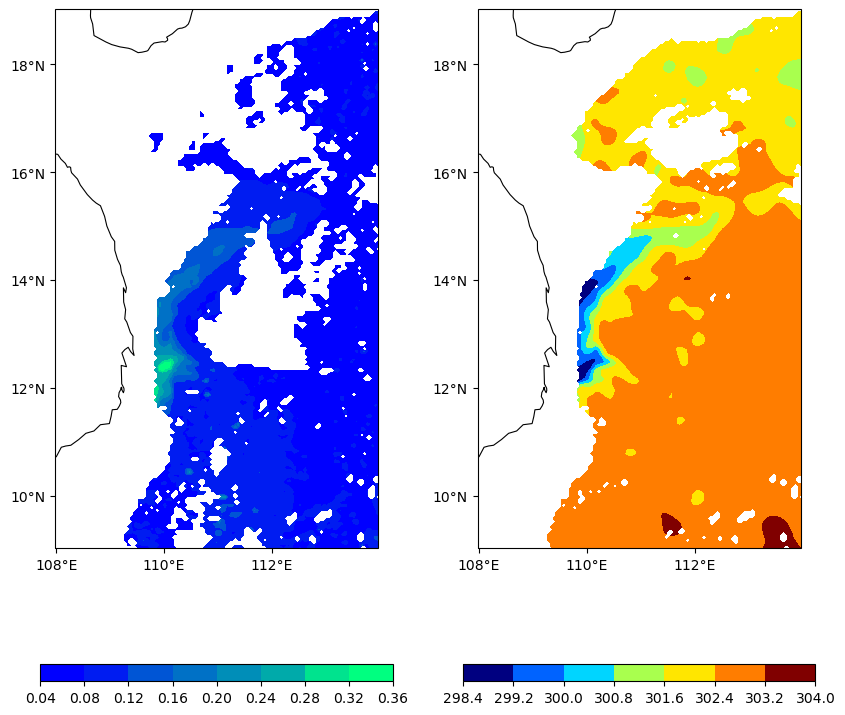

In [7]:
date = "2005-05-17"
day = 138

fig, axs = plt.subplots(nrows=1, ncols=2, subplot_kw={"projection" : cart_proj}, figsize = [10,10])

plot_data(lons, lats, chl.sel(time = date).CHL, "winter", ax = axs[0])
plot_data(lons, lats, temp.sel(time = date).analysed_sst, "jet", ax = axs[1])

In [14]:
chl_clima = climatology(chl)
temp_clima = climatology(temp)

In [9]:
chl_clima

<xarray.Dataset>
Dimensions:  (time: 366, lat: 201, lon: 121)
Coordinates:
  * lon      (lon) float32 108.0 108.0 108.1 108.1 ... 113.8 113.9 113.9 114.0
  * lat      (lat) float32 9.025 9.075 9.125 9.175 ... 18.88 18.92 18.98 19.02
  * time     (time) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
Data variables:
    CHL      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

<GeoAxesSubplot:>

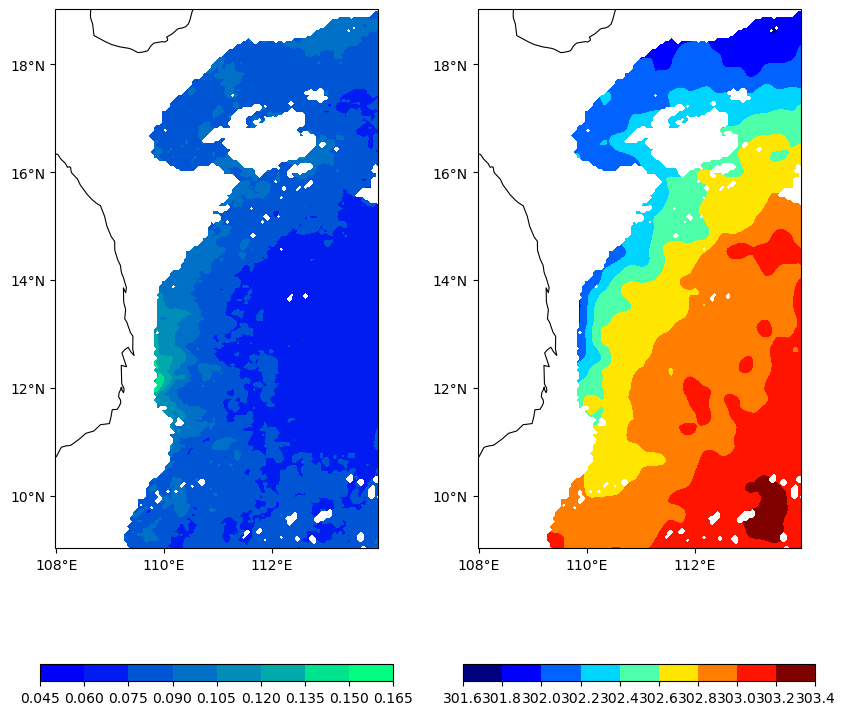

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, subplot_kw={"projection" : cart_proj}, figsize = [10,10])

plot_data(lons, lats, chl_clima.sel(time = day).CHL, "winter", ax = axs[0])
plot_data(lons, lats, temp_clima.sel(time = day).analysed_sst, "jet", ax = axs[1])

In [15]:
temp_diff = anomalies(temp, temp_clima, "2005-05-21")
chl_diff = anomalies(chl, chl_clima, "2005-05-21")

<GeoAxesSubplot:>

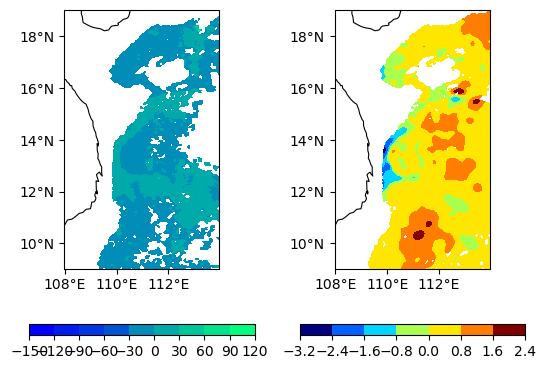

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, subplot_kw={"projection" : cart_proj})

plot_data(lons, lats, chl_diff.CHL, "winter", ax = axs[0])
plot_data(lons, lats, temp_diff.analysed_sst, "jet", ax = axs[1])

In [13]:
chl_diff

<xarray.Dataset>
Dimensions:    (lon: 121, lat: 201)
Coordinates:
  * lon        (lon) float32 108.0 108.0 108.1 108.1 ... 113.8 113.9 113.9 114.0
  * lat        (lat) float32 9.025 9.075 9.125 9.175 ... 18.88 18.92 18.98 19.02
    dayofyear  int64 142
Data variables:
    CHL        (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [17]:
date = "2005-05-21"
labels_matrix = cluster_data(chl, temp, date)

ValueError: Input X contains infinity or a value too large for dtype('float32').

<GeoAxesSubplot:>

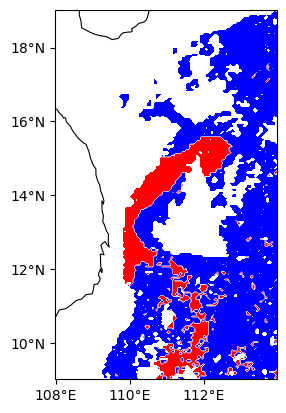

In [ ]:
plot_data(lons, lats, labels_matrix, cmap = "bwr_r", cbar = False)

In [ ]:
temp.groupby("time.dayofyear").std("time", skipna = True).sel(dayofyear = int(day)).analysed_sst

<xarray.DataArray 'analysed_sst' (lat: 201, lon: 121)>
array([[       nan,        nan,        nan, ..., 0.65008175, 0.6459717 ,
        0.64422387],
       [       nan,        nan,        nan, ..., 0.65305835, 0.649268  ,
        0.6467136 ],
       [       nan,        nan,        nan, ..., 0.6574758 , 0.65444803,
        0.6535096 ],
       ...,
       [       nan,        nan,        nan, ..., 1.1018064 , 1.125349  ,
        1.139631  ],
       [       nan,        nan,        nan, ...,        nan, 1.1219522 ,
        1.1349871 ],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * lon        (lon) float32 108.0 108.0 108.1 108.1 ... 113.8 113.9 113.9 114.0
  * lat        (lat) float32 9.025 9.075 9.125 9.175 ... 18.88 18.92 18.98 19.02
    dayofyear  int64 138

In [ ]:
chl.CHL[1].to_numpy()


chl.CHL[1].

array([0.09557264, 0.09662817, 0.09676451, ..., 0.41400817, 0.42503595,
              nan], dtype=float32)

In [ ]:
ch_array = np.copy(chl.CHL)

# ch_array[~np.isnan(ch_array)] = 1
# ch_array[np.isnan(ch_array)] = 0

# ch_array.sum(axis = 0)

# plot_data(lons, lats, ch_array.sum(axis = 0), cmap = "Blues", cbar = False)

In [37]:
ch_array = chl.copy()

#.groupby("time.dayofyear")
#groupby("time.dayofyear").sum()
#ch_array.CHL[:,:] == np.nan
#ch_array.fillna(0).where(ch_array.CHL != 0., 1)
np.any(ch_array.CHL.to_numpy() == 0, axis = 0).shape
#CHL.where(ch_array != 0, .1)
#ych_array.fillna(0)


(121, 5480)

In [16]:
ch_array.where(ch_array == np.nan, 0)

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 121, time: 5480)
Coordinates:
  * lon      (lon) float32 108.0 108.0 108.1 108.1 ... 113.8 113.9 113.9 114.0
  * lat      (lat) float32 9.025 9.075 9.125 9.175 ... 18.88 18.92 18.98 19.02
  * time     (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2018-01-01
Data variables:
    CHL      (lat, lon, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0